In [2]:
##Task 2 Academic Methods
#1. Retrieve stock data. Plot stock prices over time.
#2. Analyze stock returns. Present a end-of-period correlation matrix. Present correlation coefficients between all stocks over time graphically for the last year in your analysis.
#3. Calculate the market risk premium and present it graphically in a Boxplot.
#4. Perform a CAPM regression for each stock. Plot for each day of the last year, CAPM’s expected and real excess returns on the market risk premium for one of the stocks.

In [4]:
!pip install pandas_datareader

In [5]:
!pip install yfinance matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import random
import statsmodels.api as sm
import pandas_datareader as pdr
import seaborn as sns
import yfinance as yf
from datetime import date
import pandas_datareader.data as web

## 1. Retrieve stock data. Plot stock prices over time. Mota-Engil (EGL.LS), Ibersol (IBS.LS), EDP Renovaveis (EDPR.LS) Index: PSI (PSI20.LS)

In [4]:
#define the ticker symbol and the date range
ticker = ['EGL.LS', 'IBS.LS', 'EDPR.LS']
start_date = '2013-01-01'
end_date = '2017-01-01'

#Retreive the stock data
data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']                    

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 3 completed

3 Failed downloads:
['IBS.LS', 'EGL.LS', 'EDPR.LS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [13]:
#plot the closing prices
plt.figure(figsize=(12, 6))

#plot each stock's closing price
for ticker in ticker:
    plt.plot(data[ticker], label=ticker)
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (in Local Currency)')
plt.legend()
plt.show()


NameError: name 'data' is not defined

<Figure size 1200x600 with 0 Axes>

In [13]:
##2. Analyze stock returns. Present a end-of-period correlation matrix. Present correlation coefficients between all stocks over time graphically for the last year in your analysis.

In [14]:
#calculate daily returns
returns = data.pct_change().dropna()
print(returns)

Ticker                      EDPR.LS    EGL.LS    IBS.LS
Date                                                   
2013-01-03 00:00:00+00:00  0.002717  0.043210  0.000000
2013-01-04 00:00:00+00:00  0.003695  0.052663  0.025000
2013-01-07 00:00:00+00:00 -0.001718  0.064081 -0.019512
2013-01-08 00:00:00+00:00 -0.001721 -0.005283  0.004975
2013-01-09 00:00:00+00:00  0.016991  0.008497  0.000000
...                             ...       ...       ...
2016-12-23 00:00:00+00:00  0.004248  0.008140  0.008064
2016-12-27 00:00:00+00:00  0.003553 -0.000621 -0.008000
2016-12-28 00:00:00+00:00 -0.006407 -0.002486  0.000000
2016-12-29 00:00:00+00:00  0.008654  0.001246  0.000000
2016-12-30 00:00:00+00:00  0.015478  0.001867  0.007258

[1022 rows x 3 columns]


In [16]:
#create matrix
matrix = returns.corr().round(2)
matrix.style.background_gradient()
print("End-of-Period Correlation Matrix:")
print(matrix)


End-of-Period Correlation Matrix:
Ticker   EDPR.LS  EGL.LS  IBS.LS
Ticker                          
EDPR.LS     1.00    0.37    0.12
EGL.LS      0.37    1.00    0.11
IBS.LS      0.12    0.11    1.00


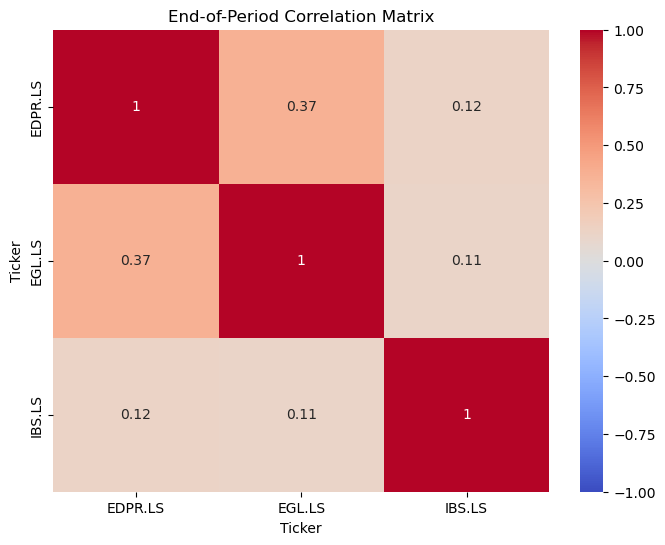

In [17]:
#plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("End-of-Period Correlation Matrix")
plt.show()

In [18]:
##3. Calculate the market risk premium and present it graphically in a Boxplot.

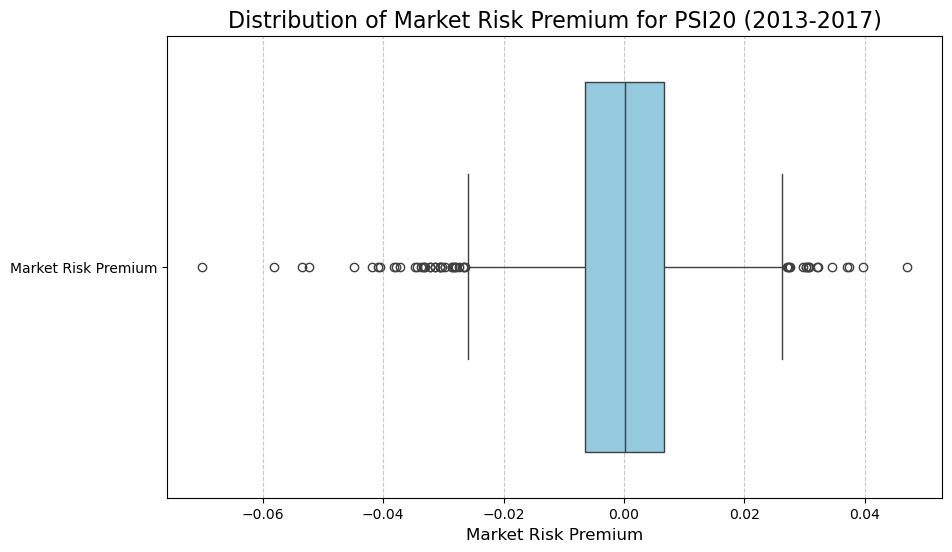

In [39]:
#index info
index = yf.Ticker("PSI20.LS")
data = index.history(start="2013-01-01", end="2017-12-31")

#daily returns for index
data['Daily Return'] = data['Close'].pct_change()

#risk-free rate data from FRED (IRLTLT01PTM156N - Portugal Long-Term Government Bond Yield)

rf_data = web.DataReader('IRLTLT01PTM156N', 'fred', start='2013-01-01', end='2017-12-31')

#convert the annual risk-free rate to a daily rate
rf_data = rf_data / 100  
daily_rf_data = (1 + rf_data) ** (1 / 252) - 1  

#convert the FRED data timezone to match Yahoo Finance data (Europe/Lisbon)
daily_rf_data.index = daily_rf_data.index.tz_localize('UTC')  # Ensure the FRED data is in UTC
daily_rf_data.index = daily_rf_data.index.tz_convert('Europe/Lisbon')  # Convert to Lisbon timezone

#ensure the risk-free rate data is a single column Series
rf_data_daily = daily_rf_data.squeeze()  # Converts to a Series if it's a DataFrame

#align risk-free data with PSI20.LS data making sure both risk free and index data are on the same timeframe
rf_data_daily = rf_data_daily.reindex(data.index,  method='ffill')

#calculate mrp
data['Market Risk Premium'] = data['Daily Return'] - rf_data_daily

#plot the Boxplot for mrp
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Market Risk Premium']].dropna(), orient="h", color="skyblue")
plt.title("Distribution of Market Risk Premium for PSI20 (2013-2017)", fontsize=16)
plt.xlabel("Market Risk Premium", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [41]:
##4. Perform a CAPM regression for each stock. Plot for each day of the last year, CAPM’s expected and real excess returns on the market risk premium for one of the stocks.
#calculated expected and real excess returns on MRP for EDPR.LS as shown in the last cell

In [43]:
#CAPM
RISKY_ASSET = 'EGL.LS'
MARKET_BENCHMARK = 'PSI20.LS'
START3 = '2013-01-01'
END3 = '2017-01-01'

df = yf.download([RISKY_ASSET, MARKET_BENCHMARK], start=START3, end=END3)

#Resample to monthly data and calculate the simple returns
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset',
 MARKET_BENCHMARK: 'market'}) \
 .resample('ME') \
 .last() \
 .pct_change() \
 .dropna()

#Calculate beta using the covariance approach
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

#Prepare the input and estimate the CAPM as a linear regression:
y = X.pop('asset')
X = sm.add_constant(X)
capm_model = sm.OLS(y, X).fit()

print(capm_model.summary())

[*********************100%***********************]  2 of 2 completed

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     39.23
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.66e-07
Time:                        17:25:57   Log-Likelihood:                 42.061
No. Observations:                  44   AIC:                            -80.12
Df Residuals:                      42   BIC:                            -76.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0146      0.014      1.010      0.3

In [45]:
RISKY_ASSET = 'IBS.LS'
MARKET_BENCHMARK = 'PSI20.LS'
START3 = '2013-01-01'
END3 = '2017-01-01'

df = yf.download([RISKY_ASSET, MARKET_BENCHMARK], start=START3, end=END3)

#Resample to monthly data and calculate the simple returns
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset',
 MARKET_BENCHMARK: 'market'}) \
 .resample('ME') \
 .last() \
 .pct_change() \
 .dropna()

#Calculate beta using the covariance approach
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

#Prepare the input and estimate the CAPM as a linear regression:
y = X.pop('asset')
X = sm.add_constant(X)
capm_model = sm.OLS(y, X).fit()

print(capm_model.summary())

[*********************100%***********************]  2 of 2 completed

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     12.31
Date:                Thu, 05 Dec 2024   Prob (F-statistic):            0.00109
Time:                        17:25:58   Log-Likelihood:                 56.534
No. Observations:                  44   AIC:                            -109.1
Df Residuals:                      42   BIC:                            -105.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0267      0.010      2.574      0.0

In [47]:
edpr = 'EDPR.LS'
MARKET_BENCHMARK1 = 'PSI20.LS'
START3 = '2013-01-01'
END3 = '2017-01-01'

df = yf.download([edpr, MARKET_BENCHMARK1], start=START3, end=END3)

#Resample to monthly data and calculate the simple returns
X = df['Adj Close'].rename(columns={edpr: 'asset',
 MARKET_BENCHMARK1: 'market'}) \
 .resample('ME') \
 .last() \
 .pct_change() \
 .dropna()

#Calculate beta using the covariance approach
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

#Prepare the input and estimate the CAPM as a linear regression:
y = X.pop('asset')
X = sm.add_constant(X)
capm_model = sm.OLS(y, X).fit()

print(capm_model.summary())

[*********************100%***********************]  2 of 2 completed

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     18.76
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           9.02e-05
Time:                        17:25:58   Log-Likelihood:                 74.696
No. Observations:                  44   AIC:                            -145.4
Df Residuals:                      42   BIC:                            -141.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0147      0.007      2.134      0.0

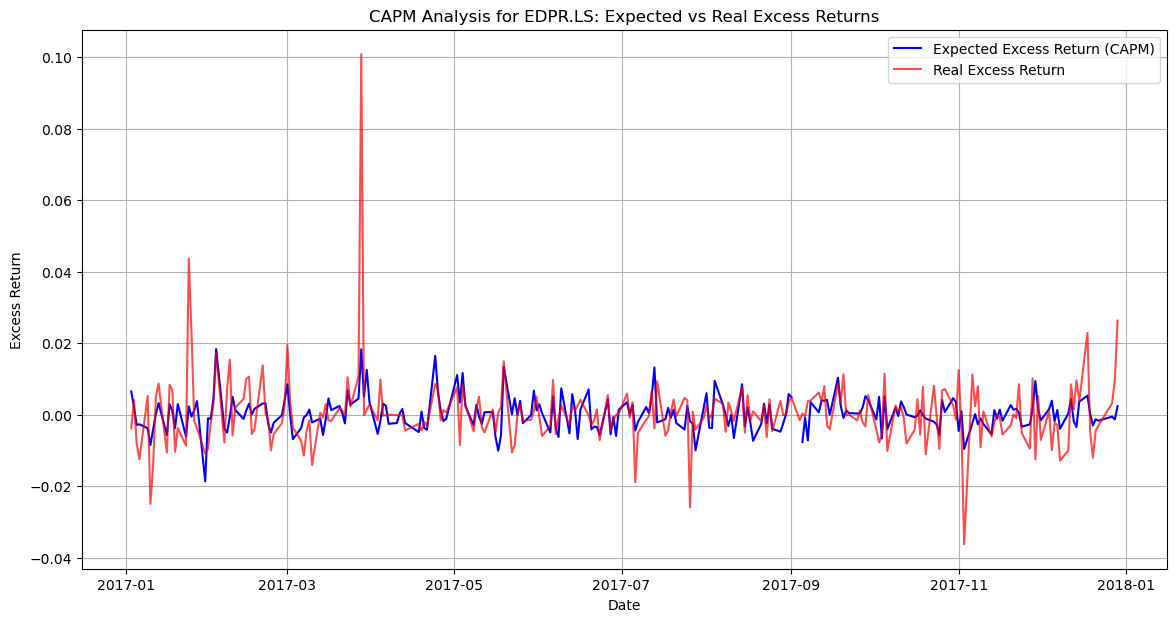

In [49]:
#historical data
start_date = "2017-01-01"
end_date = "2017-12-31"
edpr = yf.Ticker("EDPR.LS")
index = yf.Ticker("PSI20.LS")

#daily historical data
edpr_data = edpr.history(start=start_date, end=end_date)
index_data = index.history(start=start_date, end=end_date)

#daily returns
edpr_data["Daily Return"] = edpr_data["Close"].pct_change()
index_data["Daily Return"] = index_data["Close"].pct_change()

#beta
covariance = edpr_data["Daily Return"].cov(index_data["Daily Return"])
market_variance = index_data["Daily Return"].var()
beta = covariance / market_variance

#expected excess return, market risk premium used from question 3
edpr_data["Expected Excess Return"] = beta * data["Market Risk Premium"]

#align risk-free rate data with EDPR.LS data, used ai to get this code to solve error
#ensure daily_rf_data is a Series and forward-fill missing values
if isinstance(daily_rf_data, pd.DataFrame):
    daily_rf_data = daily_rf_data.squeeze()

daily_rf_data = daily_rf_data.reindex(edpr_data.index, method="ffill")

#real excess returns for edpr
edpr_data["Real Excess Return"] = edpr_data["Daily Return"] - daily_rf_data

#plot
plt.figure(figsize=(14, 7))
plt.plot(edpr_data.index, edpr_data["Expected Excess Return"], label="Expected Excess Return (CAPM)", color="blue")
plt.plot(edpr_data.index, edpr_data["Real Excess Return"], label="Real Excess Return", color="red", alpha=0.7)
plt.title("CAPM Analysis for EDPR.LS: Expected vs Real Excess Returns")
plt.xlabel("Date")
plt.ylabel("Excess Return")
plt.legend()
plt.grid()
plt.show()